In [1]:
import torch
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor, SnapshotEnsembleRegressor
import matplotlib.pyplot as plt
from fitting import create_ensemble, CustomLoss, get_data, get_datasets

import sys
sys.path.append("../")

folder = ""
all_k, all_images, bins, xx = get_data(folder)
train_dset, test_dset = get_datasets(all_k, all_images)

bandwidth = torch.tensor(0.0)
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, "alpha_1e-3")
ensemble = ensemble
ensemble.cpu();

In [2]:
all_k.shape

torch.Size([21, 2])

In [3]:
train_k = train_dset.k
train_k = train_k.cuda()

train_im = train_dset.images
train_im = train_im.cpu()

test_k = test_dset.k
test_k = test_k.cuda()

test_im = test_dset.images
test_im = test_im.cpu()

In [4]:
recompute_images = False
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = dist.sample([100000]).cuda()

        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1].cpu())[0].unsqueeze(0) for i in range(len
                                                                          (ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()

        torch.save(model_pred, "model_pred_images.pt")
    else:
        model_pred = torch.load("model_pred_images.pt")


In [5]:
# compare initial beam distributions
from torch_track import Beam

# generate beams from model
pred_initial_beams = [ele.beam_generator() for ele in ensemble]


In [6]:
from visualization import add_image, add_projection, add_image_projection
from utils import calc_rms_size
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase


# create gridspec
def create_figure():
    fig,axes = plt.subplots(3, 5)
    fig.subplots_adjust(wspace=0.35, right=0.975, top=0.975)
    fig.set_size_inches(8,4)
    gs = axes[-2,-2].get_gridspec()
    for ax in axes[-2:,-2:].flatten():
        ax.remove()
    axbig = fig.add_subplot(gs[-2:,-2:])

    return fig, axes, axbig

pred_initial_beams = [ele.beam_generator() for ele in ensemble]


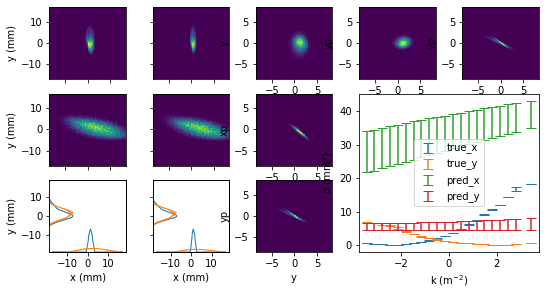

In [17]:
# choose image indexes for comparison
image_idxs = [0,1]
image_vmax = None
image_bins = bins
image_linewidth = 1

# choose phase spaces to plot
phase_spaces = [["x","y"],["x","xp"],["y","yp"],["x","yp"],["y","yp"]]
phase_space_bins = bins / 2

# quad scan
quad_scan_scale = 1e6

# generate plot skeleton
fig, axes, axbig = create_figure()

# add images to plot
for j, idx in enumerate(image_idxs):

    axes[0][j].pcolor(xx[0]*1e3,xx[1]*1e3, all_images[idx,0].cpu(),vmax=image_vmax)
    axes[1][j].pcolor(xx[0]*1e3,xx[1]*1e3, model_pred[idx,0].cpu(),vmax=image_vmax)

    axes[0][j].collections[0].set_rasterized(True)

    colors = ["C0","C1"]
    axa = axes[2][j].twinx()
    axb = axes[2][j].twiny()

    for h, ele in enumerate([all_images.cpu(), model_pred.cpu()]):
        axa = add_image_projection(axa, ele[idx], image_bins, "x", scale_x=1e3,
                                   c=colors[h])
        axb = add_image_projection(axb, ele[idx], image_bins, "y", scale_x=1e3, c=colors[h])

    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=image_linewidth)
        ele.get_lines()[0].set(zorder=0)

    axa.set_ylim(0, axa.get_ylim()[-1]*3.0)
    axb.set_xlim(0, axb.get_xlim()[-1]*3.0)
    axa.set_yticks([])
    axb.set_xticks([])

for ax in axes[:,0]:
    ax.set_ylabel("y (mm)")

for ax in axes[-1, :2]:
    ax.set_xlabel("x (mm)")

for ax in axes[:,1]:
    ax.set_yticklabels([])
for ax in axes[:2, :2].flatten():
    ax.set_xticklabels([])

# get list of axes for plotting the phase space projections
ph_axes = [*axes[:,2], axes[0,3], axes[0,4]]
# add phase space projections
for ax, pair in zip(ph_axes, phase_spaces):
    _, pred_image = add_image(ax, *pair, pred_initial_beams, [phase_space_bins]*2,
                              scale_axis=1e3)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])


# add quad scan results
quad_scan_ax = axbig
means, variances = calc_rms_size(xx, all_images.cpu())
pmeans, pvariances = calc_rms_size(xx, model_pred)


k = all_k[:, 0].cpu()
mean_variance = torch.mean(variances, dim=-2).cpu() * quad_scan_scale
error_variance = torch.std(variances, dim=-2).cpu() * quad_scan_scale

quad_scan_ax.errorbar(k, mean_variance[...,0], error_variance[...,0],capsize=5,ls='', label="true_x")
quad_scan_ax.errorbar(k, mean_variance[...,1], error_variance[...,1],capsize=5,ls='', label="true_y")

mean_pvariance = torch.mean(pvariances, dim=-2) * quad_scan_scale
error_pvariance = torch.std(pvariances, dim=-2) * quad_scan_scale

quad_scan_ax.errorbar(k, mean_pvariance[...,0], error_pvariance[...,0],capsize=5,ls='', label="pred_x")
quad_scan_ax.errorbar(k, mean_pvariance[...,1], error_pvariance[...,1],capsize=5,ls='', label="pred_y")

quad_scan_ax.set_xlabel("k (m$^{-2}$)")
quad_scan_ax.set_ylabel("$\sigma$ (mm$^2$)")
quad_scan_ax.legend()


In [8]:
all_images.shape

torch.Size([21, 2, 180, 180])